# MRI Dementia Classification - CNN Model
This model is used for MRI classification of dementia with 4 known stages (Non-Demented, Mild Demented, Moderate Demented and Very Mild Demented). Severe onset dementia is known as Alzheimer's Disease which will not be covered in this analysis. All data sourced from https://www.kaggle.com/datasets/matthewhema/mri-dementia-augmentation-no-data-leak

After continuously getting a low F1 score of no higher than 0.41, we realized that there's an imbalance of the test data and found an alternative data source that not only is rotationally augmented, but there are color color washes to monochrome RBG channels further increasing the data set to become more balanced. This data is downloaded from https://www.kaggle.com/datasets/uraninjo/augmented-alzheimer-mri-dataset

In [1]:
# Import Dependencies and Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import random
import splitfolders
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
# Load MRI Dataset
import kagglehub

# Download original dataset that is unbalanced
path = kagglehub.dataset_download("matthewhema/mri-dementia-augmentation-no-data-leak")

# # Download augmented dataset that is balanced
# path = kagglehub.dataset_download("uraninjo/augmented-alzheimer-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/ingridblankevoort/.cache/kagglehub/datasets/matthewhema/mri-dementia-augmentation-no-data-leak/versions/1


## Split images into train, test, val folders
Only run this if using on the augmented data

In [3]:
# # Split the dataset into training, validation, and test sets
# splitfolders.ratio(path + '/AugmentedAlzheimerDataset', output="data_split_trainTestVal", seed=1337, ratio=(.7, .15, .15))

# # Show path to output folder
# print("Path to output folder:", os.path.abspath("data_split_trainTestVal"))

## Image Processing

Here we're leveraging a function called ImageDataGenerator() from the Tensor library to combine all of the operations of rescaling, setting our target size, batch size, etc to prep them into respective bins - Train, Test and Validation. 

In [3]:
# Set local data paths for orginal kaggle dataset (matthewhema)
train_dir = path + '/Train/Train'
val_dir = path + '/Val/Val'
test_dir = path + '/Test/Test'

# # Set local data paths for augmented kaggle dataset (uraninjo)
# train_dir = 'data_split_trainTestVal/train'
# val_dir = 'data_split_trainTestVal/val'
# test_dir = 'data_split_trainTestVal/test'

# Store ImageDataGenerator parameters in a dictionary
imageDataGenerator_params = {
    'rescale': 1./255,
    'rotation_range': 20,
    'width_shift_range': 0.2,
    'height_shift_range': 0.2,
    'shear_range': 0.2,
    'zoom_range': 0.2,
    'horizontal_flip': True,
    'fill_mode': 'nearest'   
}

In [4]:
# Image Generators Variables

# Resize all input images to 240x240
image_size = (240, 240)

#Number of images the model processes before updating weights
batch_size = 32

# Set the color space
color_mode = 'rgb'

# Class mode
class_mode = 'categorical'

# Define the class labels
class_labels = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']

In [5]:
# Rescaling [0,1] for neural networks to process normalized values
train_datagen = ImageDataGenerator(imageDataGenerator_params)
val_datagen = ImageDataGenerator(imageDataGenerator_params)
test_datagen = ImageDataGenerator(imageDataGenerator_params)

# Create Generators for Train, Val and Test
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode=class_mode, 
    shuffle=False
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode=class_mode, 
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode=class_mode, 
    shuffle=False
)


Found 11350 images belonging to 4 classes.
Found 960 images belonging to 4 classes.
Found 960 images belonging to 4 classes.


### Visualize the data 

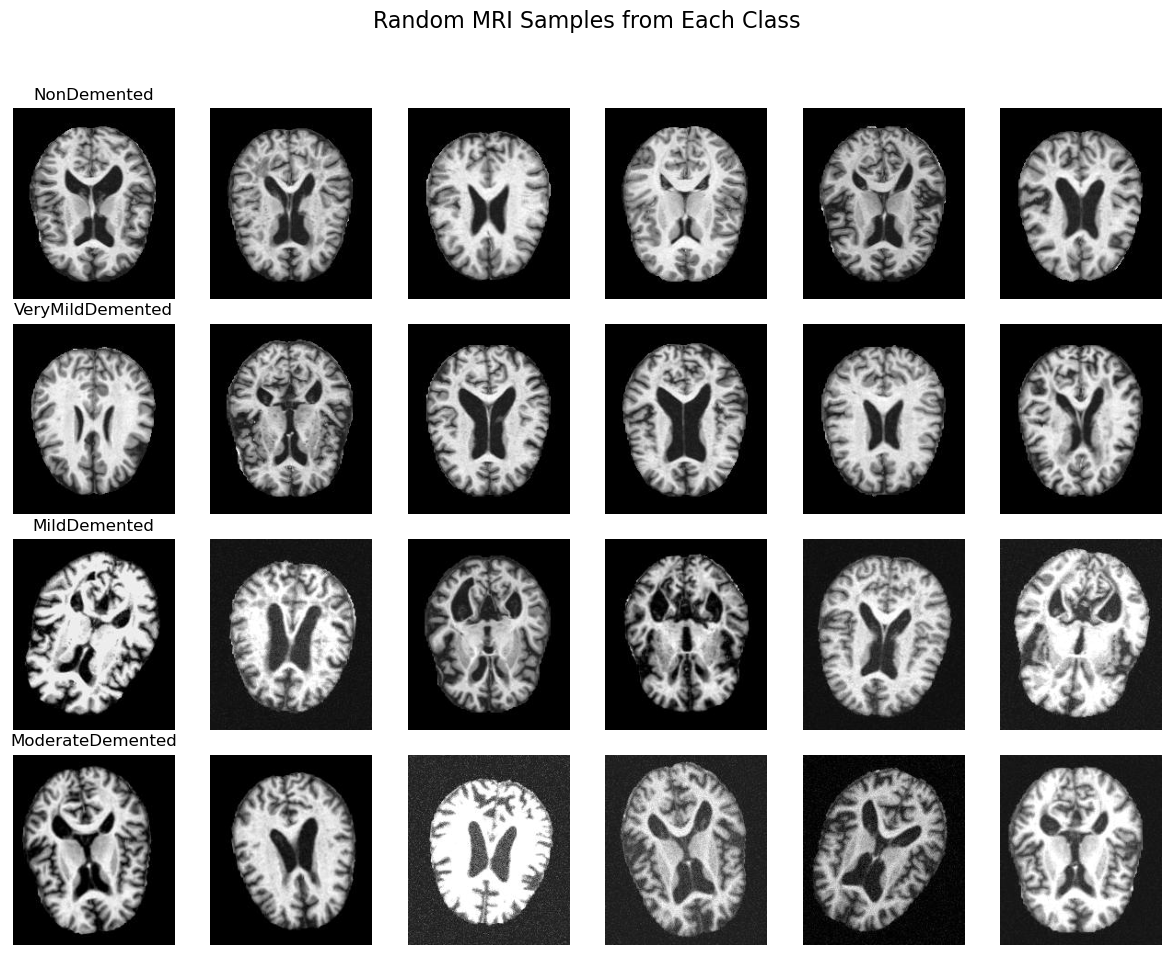

In [6]:
# Corresponding actual folder names in the dataset

# Use this folder map for the original dataset
base_dir = path + '/Train/Train'
folder_map = {
    'NonDemented': 'Non Demented',
    'VeryMildDemented': 'Very MildDemented',
    'MildDemented': 'Mild Demented/Mild Demented Merge',
    'ModerateDemented': 'Moderate Demented/Moderate Demented Merge'
}

# # Use this folder map for the augmented dataset
# base_dir = 'data_split_trainTestVal/train'
# folder_map = {
#     'NonDemented': 'NonDemented',
#     'VeryMildDemented': 'VeryMildDemented',
#     'MildDemented': 'MildDemented',
#     'ModerateDemented': 'ModerateDemented'
# }

# Set up subplots
fig, axes = plt.subplots(len(class_labels), 6, figsize=(12, 10))
if len(class_labels) == 1:
    axes = np.expand_dims(axes, axis=0)

fig.suptitle('Random MRI Samples from Each Class', fontsize=16)

for row_idx, label in enumerate(class_labels):
    folder_name = folder_map[label]
    class_path = os.path.join(base_dir, folder_name)

    if not os.path.exists(class_path):
        print(f"Directory not found for: {folder_name}")
        continue

    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if len(image_files) == 0:
        print(f"No images found in folder: {folder_name}")
        continue

    # Safe sampling (with replacement if fewer than 6)
    sampled_files = random.choices(image_files, k=min(6, len(image_files)))

    for col_idx in range(6):
        ax = axes[row_idx, col_idx]
        ax.axis('off')

        if col_idx < len(sampled_files):
            img_path = os.path.join(class_path, sampled_files[col_idx])
            image = mpimg.imread(img_path)
            ax.imshow(image, cmap='gray')
            if col_idx == 0:
                ax.set_title(label)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [7]:
# Check the class indices for each generator
train_class_indices = train_generator.class_indices
val_class_indices = val_generator.class_indices
test_class_indices = test_generator.class_indices

# Print the class indices
print("Train Class indices:", train_class_indices)
print("Validation Class indices:", val_class_indices)
print("Test Class indices:", test_class_indices)

# Check color space
print(train_generator.image_shape)  # should be (240, 240, 3)

Train Class indices: {'Mild Demented': 0, 'Moderate Demented': 1, 'Non Demented': 2, 'Very MildDemented': 3}
Validation Class indices: {'Mild Demented': 0, 'Moderate Demented': 1, 'Non Demented': 2, 'Very MildDemented': 3}
Test Class indices: {'Mild Demented': 0, 'Moderate Demented': 1, 'Non Demented': 2, 'Very MildDemented': 3}
(240, 240, 3)


---

## Create the Architecture of the Model 
In this section, simply uncomment the block of code (/ + CMND) for which version of the model you want to run. Be sure to change the version number when saving the filenames down below

### CNN Model sequential_3_model_V1 // F1 Score 0.51
Start with a basic Convcoluation layer and dense layer

In [9]:
# # Build the CNN Model from scratch
# model = Sequential([
#     # Input Layer
#     Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
#     MaxPooling2D((2, 2)),

#     # Hidden Layers
#     Conv2D(64, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),

#     # Flattening Layer and Dense Layers
#     Flatten(),
#     Dense(256, activation='relu'),
#     Dropout(0.2),
#     Dense(4, activation='softmax')  # 4 output classes
# ])

# # Compile the model
# model.compile(optimizer=Adam(learning_rate=1e-4),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])


### CNN Model sequential_4_model_V2 // F1 Score 0.96
Add another convolution layer and dense later doubling the number of neurons. 
Even with a high F1 score, there were some suspicious results when trying to test the model on individual MRI images. It was found out that the class_order wasn't in the right order so we corrected that in V3.

In [10]:
# # Build the CNN Model from scratch
# model = Sequential([
#     # Input Layer
#     Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
#     MaxPooling2D((2, 2)),

#     # Hidden Layers
#     Conv2D(64, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Conv2D(128, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),

#     # Flattening Layer and Dense Layers
#     Flatten(),
#     Dense(256, activation='relu'),
#     Dropout(0.2),
#     Dense(512, activation='relu'),
#     Dropout(0.2),
#     Dense(4, activation='softmax')  # 4 output classes
# ])

# # Compile the model
# model.compile(optimizer=Adam(learning_rate=1e-4),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

### CNN Model sequential_3_model_V3 // F1 Score 0.37
Corrected the class order and changed to gray scale. This yielded a way lower F1 score probabably due changing the color_mode to grayscale. Grayscale doesn't provide enough meaningful data to pull out the minute features to actually create an accurate model.

In [11]:
# # Build the CNN Model from scratch
# model = Sequential([
#     # Input Layer
#     Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
#     MaxPooling2D((2, 2)),

#     # Hidden Layers
#     Conv2D(64, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Conv2D(128, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),

#     # Flattening Layer and Dense Layers
#     Flatten(),
#     Dense(256, activation='relu'),
#     Dropout(0.2),
#     Dense(512, activation='relu'),
#     Dropout(0.2),
#     Dense(4, activation='softmax')  # 4 output classes
# ])

# # Compile the model
# model.compile(optimizer=Adam(learning_rate=1e-4),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

### CNN Model sequential_4_model_V4 // F1 Score 0.40
Went back to colorspace rgb. Kept the same CNN model configuration. After training the model and running it on the test data, it yielded a way lower F1 score than an accuracy score of 0.98. There's a -39% difference. This is probably due to the the imbalance of test data which is supposedly common with medical imaging. In this case non demented dominates the dataset so that could be contributing to the high accuracy. 

Also since we moved to a more ordinal encoding of the class labels, this imbalance is seen even more. 

In [12]:
# # Build the CNN Model from scratch
# model = Sequential([
#     # Input Layer
#     Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
#     MaxPooling2D((2, 2)),

#     # Hidden Layers
#     Conv2D(64, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Conv2D(128, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),

#     # Flattening Layer and Dense Layers
#     Flatten(),
#     Dense(256, activation='relu'),
#     Dropout(0.2),
#     Dense(512, activation='relu'),
#     Dropout(0.2),
#     Dense(4, activation='softmax')  # 4 output classes
# ])

# # Compile the model
# model.compile(optimizer=Adam(learning_rate=1e-4),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

### CNN Model sequential_X_model_V7 // F1 Score 0.28
Try: Regulization for Keras 
Assign weights based off the minority class, increased dropout to 0.5, rebalanced dataset 

In [13]:
# # Build the CNN Model from scratch
# model = Sequential([
#     # Input Layer
#     Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
#     MaxPooling2D((2, 2)),

#     # Hidden Layers
#     Conv2D(64, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Conv2D(128, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),

#     # Flattening Layer and Dense Layers
#     Flatten(),
#     Dense(256, activation='relu'),
#     Dropout(0.5),
#     Dense(512, activation='relu'),
#     Dropout(0.5),
#     Dense(4, activation='softmax')  # 4 output classes
# ])

# # Compile the model
# model.compile(optimizer=Adam(learning_rate=1e-4),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

### CNN Model sequential_model_V8 // F1 Score 0.46
It was brought up that the data should not be ordinally encoded. This is because most CNN classifications treat labels as categorical, not ordered. Keras treats class as independent categories. So this round, we'll take out the class order attribute. Here we're also applying regulaization to help with overfitting as well as batch normalization. Also we increased the dropout to 0.5.

In [14]:
# # Build the CNN Model from scratch
# model = Sequential([
#     # Input Layer
#     Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(240, 240, 3)),
#     BatchNormalization(),
#     MaxPooling2D((2, 2)),

#     # Hidden Layers
#     Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
#     BatchNormalization(),
#     MaxPooling2D((2, 2)),

#     Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
#     BatchNormalization(),
#     MaxPooling2D((2, 2)),

#     # Flattening Layer and Dense Layers
#     Flatten(),
#     Dense(256, activation='relu'),
#     Dropout(0.5),
#     Dense(512, activation='relu'),
#     Dropout(0.5),
#     Dense(4, activation='softmax')
# ])

# # Compile the model
# model.compile(optimizer=Adam(learning_rate=1e-4),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

### CNN Model sequential_model_V9 // F1 Score 0.21
We run V8 model on the original dataset just to see what would happen. 

In [8]:
# Build the CNN Model from scratch
model = Sequential([
    # Input Layer
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(240, 240, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Hidden Layers
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Flattening Layer and Dense Layers
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/opt/anaconda3/envs/dev/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-13 18:05:36.970141: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-05-13 18:05:36.970171: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 48.00 GB
2025-05-13 18:05:36.970185: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 18.00 GB
I0000 00:00:1747181136.970200 1097638 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1747181136.970225 1097638 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0

### VGG-16 // F1 Score 0.37
Just for fun, we try leveraging an existing model (VGG-16) that specializes in image classificaion.

VGG-16 is an existing Convolutional Neural Network (CNN) proposed by the Visual Geometry Group (VGG) at the University of Oxford consisting of 16 layers, including convolutional, pooling, and fully connected layers. For details of this model go to: https://www.geeksforgeeks.org/vgg-16-cnn-model/

In [16]:
# from tensorflow.keras.applications import VGG16

# # Build a Transfer Learning Model
# base_model = VGG16(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
# base_model.trainable = False  # Freeze base

# # Build the custom classifier
# model = Sequential([
#     base_model,
#     GlobalAveragePooling2D(), # Reduces output to 1D vector
#     Dense(256, activation='relu'), # Fully connected layer with ReLU
#     Dense(512, activation='relu'), # 2nd connected layer with ReLU
#     Dropout(0.5), # Randomly turn off 50% of neurons to prevent overfitting
#     Dense(4, activation='softmax')  # Final output layer for 4 classes
# ])

# # Compile the model
# model.compile(optimizer=Adam(learning_rate=1e-4),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

### VGG-16 V10 // F1 Score 
Trying the VGG-16 Model again but this time taking the work done by a previous researcher 

In [17]:
# vgg_model = VGG16(weights="imagenet" , include_top=False , input_shape=(240,240,3))
# FROZEN_LAYERS = 4
# LEARNING_RATE = 0.0001
# for i in vgg_model.layers[-FROZEN_LAYERS:]:
#     i.trainable = False

# inputs = Input(shape=(240, 240, 3))
# x = vgg_model(inputs, training=False)

# x = Flatten()(x)  

# for units, rate in [(512, 0.5), (256, 0.3), (128, 0.3)]:
#     x = Dense(units, kernel_initializer=HeUniform())(x)
#     x = BatchNormalization()(x)
#     x = tf.keras.layers.ReLU()(x)  
#     x = Dropout(rate)(x)

# model = Model(inputs=inputs, outputs=outputs)
# outputs = Dense(4, activation="softmax")(x)
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
#               loss="categorical_crossentropy",
#               metrics=["accuracy"])

In [9]:
# Summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 238, 238, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 238, 238, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 119, 119, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 117, 117, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 117, 117, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 58, 58, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,918,148 (98.87 MB)

 Trainable params: 25,917,700 (98.87 MB)

 Non-trainable params: 448 (1.75 KB)

---

## Train the Model

In [10]:
%%time
# Train the Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10


/opt/anaconda3/envs/dev/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/opt/anaconda3/envs/dev/lib/python3.12/site-packages/keras/src/legacy/preprocessing/image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
2025-05-13 18:06:56.286866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


355/355 ━━━━━━━━━━━━━━━━━━━━ 52s 135ms/step - accuracy: 0.4004 - loss: 33.2730 - val_accuracy: 0.2698 - val_loss: 18.1984
Epoch 2/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 47s 132ms/step - accuracy: 0.4683 - loss: 33.8631 - val_accuracy: 0.5000 - val_loss: 41.8757
Epoch 3/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 48s 134ms/step - accuracy: 0.5340 - loss: 31.4584 - val_accuracy: 0.2125 - val_loss: 35.4210
Epoch 4/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 48s 135ms/step - accuracy: 0.5643 - loss: 31.7019 - val_accuracy: 0.5021 - val_loss: 26.2457
Epoch 5/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 47s 133ms/step - accuracy: 0.6473 - loss: 27.4504 - val_accuracy: 0.2500 - val_loss: 44.2124
Epoch 6/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 47s 132ms/step - accuracy: 0.6768 - loss: 26.5486 - val_accuracy: 0.5323 - val_loss: 18.1471
Epoch 7/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 47s 133ms/step - accuracy: 0.7205 - loss: 25.4617 - val_accuracy: 0.3760 - val_loss: 39.8332
Epoch 8/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 47s 134ms/step - accuracy: 0.7281 - loss

### Run the Model on Test data

In [11]:
%%time
# Evaluation on Test Set
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc:.2f}")

# Predictions   
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4644 - loss: 110.4543
Test Accuracy: 0.21
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
CPU times: user 1.07 s, sys: 537 ms, total: 1.61 s
Wall time: 1.55 s


### Analysis of Results

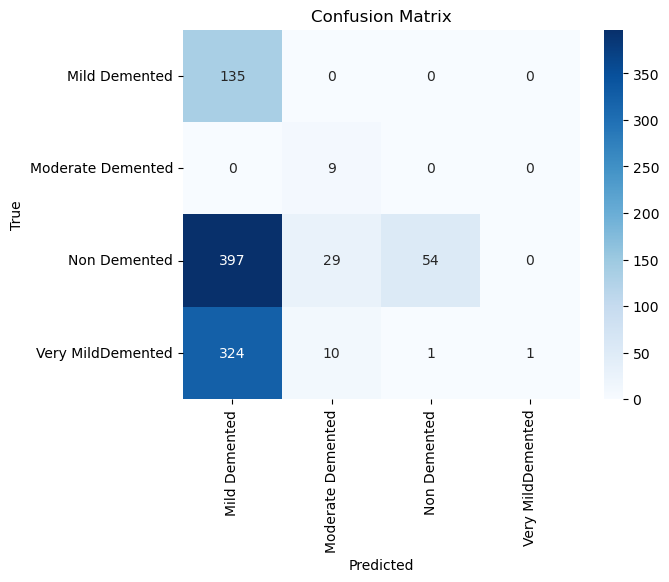

                   precision    recall  f1-score   support

    Mild Demented       0.16      1.00      0.27       135
Moderate Demented       0.19      1.00      0.32         9
     Non Demented       0.98      0.11      0.20       480
Very MildDemented       1.00      0.00      0.01       336

         accuracy                           0.21       960
        macro avg       0.58      0.53      0.20       960
     weighted avg       0.86      0.21      0.14       960



In [12]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices,
            yticklabels=test_generator.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Get class labels in correct order
labels_sorted = sorted(test_generator.class_indices, key=test_generator.class_indices.get)

# Show classification report
print(classification_report(y_true, y_pred_classes, target_names=labels_sorted))

In [13]:
# Print the number of images in each class - non and very mild are weighing the dataset down. 
import collections
print(collections.Counter(test_generator.classes))

Counter({2: 480, 3: 336, 0: 135, 1: 9})


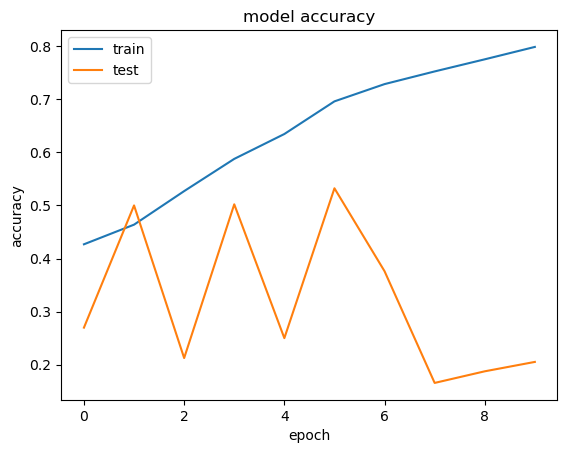

In [14]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

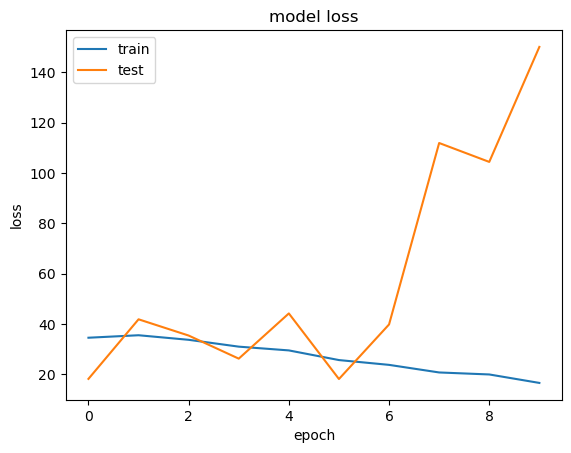

In [15]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Check class distributions

### Save the model and history into their respective files (keras and pickle)

In [16]:
# Create varibles to store the file names of the model and history 
model_name = model.name

# Set the version of the model    
version = 'V9'

model_fullfilename = 'dementia_cnn_' + model_name + '_model_' + version + '.keras'
history_fullfilename = 'dementia_cnn_' + model_name + '_history_' + version + '.pkl'

print(model_fullfilename)
print(history_fullfilename)

dementia_cnn_sequential_model_V9.keras
dementia_cnn_sequential_history_V9.pkl


In [17]:
# Save the model into an .keras file
model.save('saved_models/' + model_fullfilename)

# Save the history object into a pickle file
import pickle

with open('saved_models/' + history_fullfilename, 'wb') as file:
    pickle.dump(history.history, file)